# Lab 4 - Data Preparation & CNN Transfer Learning 

## Objective

* To load and preprocess/augment data from a non trivial dataset.
* To make use of pretrained models for image classification

**Suggested reading**: 
* [PyTorch tutorial on *Writing Custom Datasets, DataLoaders and Transforms*](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)
* [PyTorch tutorial on *Transfer Learning for Computer Vision Tutorial*](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
* [Data preparation - Wikipedia](https://en.wikipedia.org/wiki/Data_preparation)
* [Transfer learning - Stanford CNN course](https://cs231n.github.io/transfer-learning/)

**This notebook is based on PyTorch tutorials on [*Writing Custom Datasets, DataLoaders and Transforms*](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) and [*Transfer Learning for Computer Vision Tutorial*](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) by `Sasank Chilamkurthy <https://chsasank.github.io>` under the BSD license.**

## Why

**Data preparation** is important when applying machine learning to real-world problems. Mostly, data are not in a format that can be directly analysed by machine learning algorithms, and we need to preprocess the data to such a format. Often, it is also helpful to inspect data to know it (well) before machine learning, to avoid unpleasant surprises.

**Transfer learning** can help improve the performance on a particular learning problem by leveraging knowledge gained from a different but related problem. This can also alleviate the demanded resources and accelerate development. 



In [1]:
%matplotlib inline

## 1. Data Preparation

PyTorch provides many tools to make data loading easy and hopefully, to make your code more readable. With conda, we should have ``scikit-image`` (for image io and transforms) and ``pandas`` (for easier csv parsing) already.

In [2]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

### 1.1 The facial pose dataset
The dataset we are going to deal with is that of facial pose, with 68 different landmark points are annotated for each face.

**Download** the dataset from [here](https://download.pytorch.org/tutorial/faces.zip) and unzip the images to a directory named `data/faces/`.
    
**Landmarks**: the dataset comes with a csv file `face_landmarks.csv` with each row containing the image filename followed by the $x$ and $y$ coordinates of the 68 landmarks.

In [3]:
landmarks_frame = pd.read_csv('data/faces/face_landmarks.csv')
landmarks_frame.head()

,image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x,part_2_y,part_3_x,part_3_y,part_4_x,...,part_63_x,part_63_y,part_64_x,part_64_y,part_65_x,part_65_y,part_66_x,part_66_y,part_67_x,part_67_y
0,0805personali01.jpg,27,83,27,98,29,113,33,127,39,...,93,136,100,141,93,135,89,135,84,134
1,1084239450_e76e00b7e7.jpg,70,236,71,257,75,278,82,299,90,...,148,311,179,308,149,312,137,314,128,312
2,10comm-decarlo.jpg,66,114,65,128,67,142,68,156,72,...,128,162,136,167,127,166,121,165,116,164
3,110276240_bec305da91.jpg,42,140,45,161,51,180,61,200,73,...,144,197,180,189,147,204,136,208,125,209
4,1198_0_861.jpg,138,392,141,427,145,464,152,501,166,...,293,507,331,511,294,516,279,518,265,516


**Inspection**: let us take a look at the third image (index $n=2$) `10comm-decarlo.jpg`.

In [4]:
n = 2 #The index 
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].as_matrix()
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: 10comm-decarlo.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[ 66. 114.]
 [ 65. 128.]
 [ 67. 142.]
 [ 68. 156.]]


Let's write a simple helper function to show an image and its landmarks
and use it to show a sample.




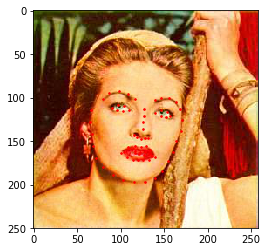

In [5]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_landmarks(io.imread(os.path.join('data/faces/', img_name)),landmarks)
plt.show()

### Define a custom torch Dataset 

``torch.utils.data.Dataset`` is an abstract class representing a dataset. Our custom dataset should inherit ``Dataset`` and **override** the following methods:

-  ``__len__`` so that ``len(dataset)`` returns the size of the dataset.
-  ``__getitem__`` to support the indexing such that ``dataset[i]`` can
   be used to get $i$\ th sample

Let's create a dataset class for our face landmarks dataset. We will read the csv in ``__init__`` but leave the reading of images to ``__getitem__``. This is memory efficient because all the images are not stored in the memory at once but read as required.

Sample of our dataset will be a dict ``{'image': image, 'landmarks': landmarks}``. Our dataset will take an
optional argument ``transform`` so that any required processing can be applied on the sample. We will see the usefulness of ``transform`` below.

In [6]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

### 1.2 Test our custom Dataset
Let's instantiate this class and iterate through the data samples. We will print the sizes of first $N$ samples and show their landmarks.




0 (324, 215, 3) (68, 2)


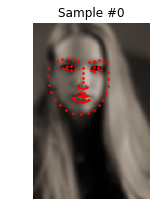

1 (500, 333, 3) (68, 2)


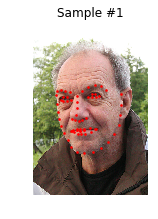

2 (250, 258, 3) (68, 2)


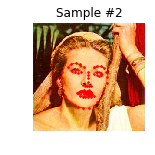

In [7]:
face_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv', root_dir='data/faces/')

fig = plt.figure()
N=3  #number to show
for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, N, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == N-1:
        #plt.show()
        break

### 1.3 Transforms

#### Define transforms
One issue we can see from the above is that the samples are not of the
same size. Most neural networks expect the images of a fixed size.
Therefore, we will need to write some prepocessing code.
Let's create three transforms:

-  ``Rescale``: to scale the image
-  ``RandomCrop``: to crop from image randomly. This is data
   augmentation.
-  ``ToTensor``: to convert the numpy images to torch images (we need to
   swap axes).

We will write them as **callable classes** instead of simple functions so
that parameters of the transform need not be passed everytime it's
called. For this, we just need to implement ``__call__`` method and
if required, ``__init__`` method. We can then use a transform like this:

```python
    tsfm = Transform(params)
    transformed_sample = tsfm(sample)
```
Observe below how these transforms had to be applied **both** on the image and
landmarks.




In [8]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is matched to output_size. 
        If int, smaller of image edges is matched to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h, 
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

#### Compose transforms and apply them to a sample

Now, we apply the transforms on a sample.

Let's say we want to rescale the shorter side of the image to 256 and
then randomly crop a square of size 224 from it. i.e, we want to compose
``Rescale`` and ``RandomCrop`` transforms.
``torchvision.transforms.Compose`` is a simple callable class which allows us
to do this.




0


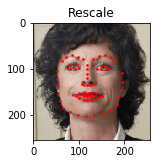

1


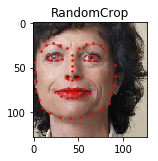

2


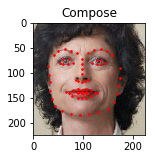

In [9]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

n=65  #Choose image 65 to apply the transform
# Apply each of the above transforms on sample.
#fig = plt.figure()
sample = face_dataset[n]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)
    print(i)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

#plt.show()

###  1.4 Iterating through the dataset
Let's put this all together to create a dataset with composed
transforms. To summarize, every time this dataset is sampled:

-  An image is read from the file on the fly
-  Transforms are applied on the read image
-  Since one of the transforms is random, data is augmentated on
   sampling

We can iterate over the created dataset with a ``for i in range``
loop as before. Here, we rescale all images to the same size of 256x256 and then crop a 224x224 subimage from each.

In [10]:
transformed_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                           root_dir='data/faces/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


However, we are losing a lot of features by using a simple ``for`` loop to
iterate over the data. In particular, we are missing out on:

-  Batching the data
-  Shuffling the data
-  Load the data in parallel using ``multiprocessing`` workers.

``torch.utils.data.DataLoader`` is an iterator which provides all these
features. Parameters used below should be clear. One parameter of
interest is ``collate_fn``. You can specify how exactly the samples need
to be batched using ``collate_fn``. However, default collate should work
fine for most use cases. Check out the [DataLoader API here](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader). 

**`num_workers`** specifies the number of workers for [multi-process data loading](https://pytorch.org/docs/stable/data.html#single-and-multi-process-data-loading). On (my) Windows, if `num_workers` is set to a positive number, there will be a `BrokenPipeError`. On (my) Linux, there is no such probem, e.g., setting `num_workers=4` works fine. I am not sure about Mac.

0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


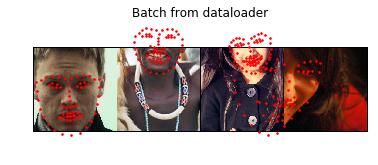

In [11]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=0)


# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks_batch[i, :, 1].numpy() + grid_border_size,
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break


## 2. CNN Transfer Learning in Computer Vision 
Next, we will train a convolutional neural network (CNN) for image classification using transfer learning. As pointed out in the [cs231n notes](https://cs231n.github.io/transfer-learning)
>  In practice, very few people train an entire Convolutional Network
   from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [12]:
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models
import time
import copy

### 2.1 Load the `ants` & `bees` Data

We will train a model to classify **ants** and **bees**. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well. This dataset is a very small subset of [imagenet](https://en.wikipedia.org/wiki/ImageNet). We will use torchvision and torch.utils.data packages for loading the data.

**Download** the data from [here](https://download.pytorch.org/tutorial/hymenoptera_data.zip) to our `data` directory and extract it there.

#### Compose the transforms

Check out the [transforms API here](https://pytorch.org/docs/stable/torchvision/transforms.html) for avaiable transforms in PyTorch.

**Note**: the numbers `[0.485, 0.456, 0.406]` and `[0.229, 0.224, 0.225]` in `Normalize` are from the [imagenet](https://en.wikipedia.org/wiki/ImageNet). See discussions [here](https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2) and also [here ](https://github.com/jacobgil/pytorch-grad-cam/issues/6).

**ImageFolder** is a method of `torchvision.datasets`. See the [`ImageFolder` API here](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder).
It assumes that images are organized in the following way: ::

    root/ants/xxx.png
    root/ants/xxy.jpeg
    root/ants/xxz.png
    .
    .
    .
    root/bees/123.jpg
    root/bees/nsdf3.png
    root/bees/asd932_.png

where 'ants', 'bees' etc. are class labels. 

In [13]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Inspect data by visualizing a few images

Let's visualize a few training images so as to understand the data augmentations.



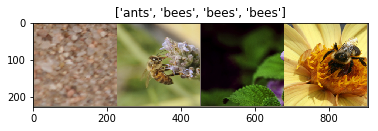

In [14]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) #Tensor to numpy format conversion
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### 2.2 Training the model

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model
-  Recording the computational time.

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``. Check out [its API here](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)

In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

#### Visualizing the model predictions

Generic function to display predictions for a few images

In [16]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### 2.3 Finetuning the convnet

Load a pretrained model and reset final fully connected layer.

In [17]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

#### Train and evaluate

We set the number of epochs small to save time. 

In [18]:
max_epochs=5;

In [19]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=max_epochs)

Epoch 0/4
----------
train Loss: 0.6768 Acc: 0.6352
val Loss: 0.2074 Acc: 0.9281

Epoch 1/4
----------
train Loss: 0.6000 Acc: 0.7828
val Loss: 0.4851 Acc: 0.8497

Epoch 2/4
----------
train Loss: 0.5160 Acc: 0.8320
val Loss: 0.3821 Acc: 0.8693

Epoch 3/4
----------
train Loss: 0.5004 Acc: 0.8033
val Loss: 0.2559 Acc: 0.9150

Epoch 4/4
----------
train Loss: 0.5568 Acc: 0.7828
val Loss: 0.2741 Acc: 0.9020

Training complete in 2m 16s
Best val Acc: 0.928105


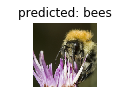

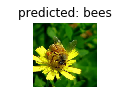

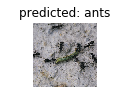

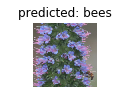

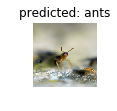

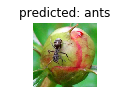

In [20]:
visualize_model(model_ft)

### 2.4 ConvNet as fixed feature extractor

Here, we need to freeze all the network except the final layer. We need to set ``requires_grad == False`` to freeze the parameters so that the gradients are not computed in ``backward()``.

You can read more about this in the [documentation](https://pytorch.org/docs/master/notes/autograd.html#excluding-subgraphs-from-backward)

In [21]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

#### Train and evaluate

On CPU this will take about half the time compared to previous scenario. This is expected as gradients don't need to be computed for most of the network. However, forward does need to be computed.

In [22]:
model_conv = train_model(model_conv, criterion, optimizer_conv, 
                         exp_lr_scheduler, num_epochs=max_epochs)

Epoch 0/4
----------
train Loss: 0.7735 Acc: 0.6393
val Loss: 0.2628 Acc: 0.9020

Epoch 1/4
----------
train Loss: 0.4453 Acc: 0.7951
val Loss: 0.1847 Acc: 0.9412

Epoch 2/4
----------
train Loss: 0.4331 Acc: 0.8115
val Loss: 0.3067 Acc: 0.8824

Epoch 3/4
----------
train Loss: 0.5007 Acc: 0.7910
val Loss: 0.1835 Acc: 0.9477

Epoch 4/4
----------
train Loss: 0.4945 Acc: 0.7582
val Loss: 0.2289 Acc: 0.9085

Training complete in 0m 44s
Best val Acc: 0.947712


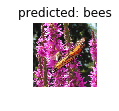

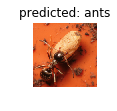

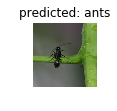

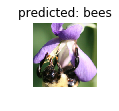

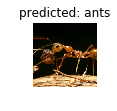

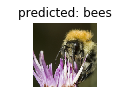

In [23]:
visualize_model(model_conv)

plt.ioff()
plt.show()

## 3. Exercises


* Construct image transforms not yet available in `torchvision.transforms` and use them to compose various manipulations of images.
* Replace the `resnet18` model with some other [pretrained models](https://pytorch.org/docs/stable/torchvision/models.html) and compare their performance.
* Take some other adventures, e.g., how about freezing all the network except the **last two** layers?
* Explore other `torchvision` APIs.